In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Load the ground truth file
def load_poses(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    poses = []
    for line in lines:
        values = list(map(float, line.split()))
        # Convert each line to a 3x4 matrix
        pose_matrix = np.array(values).reshape(3, 4)
        poses.append(pose_matrix)

    return np.array(poses)

# Calculate relative transformations between two poses
def relative_transform_mycode(pose1, pose2):
    R1, t1 = pose1[:, :3], pose1[:, 3]
    R2, t2 = pose2[:, :3], pose2[:, 3]

    # Relative rotation and translation
    R_rel = R2.T @ R1 #very close to I if same orientation
    t_rel = R2.T@(t1-t2) #translation error just substract
    return R_rel, t_rel

# Check if two poses are similar within a given threshold (loop closure criterion)
def is_loop_closure_mycode(R_rel, t_rel, rot_thresh=0.1, trans_thresh=0.1):
    # Check translation threshold
    trans_error = np.linalg.norm(t_rel)

    # Early stop to speed up
    if trans_error >= trans_thresh:
        return False

    # Check rotation threshold using angle of rotation (trace method)
    trace_val = np.trace(R_rel)
    rot_error = np.arccos((trace_val - 1) / 2) # Radians, the rot_error is angle scalar value for axis-angle representaion of the rotation

    return trans_error < trans_thresh and rot_error < rot_thresh

# The loss function is to be used with query function, for nearest neighbour search
def pose_loss(pose1, pose2, trans_parameter, rot_parameter):
    R1, t1 = pose1[:, :3], pose1[:, 3]
    R2, t2 = pose2[:, :3], pose2[:, 3]

    # Relative rotation and translation
    R_rel = R2.T @ R1 #very close to I if same orientation
    t_rel = R2.T@(t1-t2) #translation error just substract

    pose_loss = R_rel * rot_parameter + t_rel * trans_parameter
    return pose_loss

# Find loop closure pairs with temporal consistency
# early_stop = -1 means no early stop, or else stop at the epoch
def find_loop_closures_mycode(poses, min_frame_gap=40, rot_thresh=0.1, trans_thresh=0.1, early_stop = -1):
    loop_closures = []
    num_poses = len(poses)

    for i in range(num_poses):
        if early_stop != -1 and i >= early_stop:
            break
        if i % 500 == 0:
            print(f"Processing frame {i} out of {num_poses}")
        for j in range(i, num_poses):
            # If i too close to j, just skip
            if abs(i-j) <= min_frame_gap:
              continue
            # Calculate the relative transformation between frames i and j
            R_rel, t_rel = relative_transform_mycode(poses[i], poses[j])

            # Check if the relative transformation meets the loop closure criteria
            if is_loop_closure_mycode(R_rel, t_rel, rot_thresh, trans_thresh):
                loop_closures.append((i, j))

    return loop_closures


In [11]:
# Set up your parameters and load the file
file_path = '/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_poses/dataset/poses/00.txt'  # Replace with the actual file path
poses = load_poses(file_path)

# Find loop closure pairs with a minimum frame gap of 30 frames
min_frame_gap = 300
rot_thresh = 0.3  # Rotation threshold in radians
trans_thresh = 1  # Translation threshold in meters
loop_closures = find_loop_closures_mycode(poses, min_frame_gap, rot_thresh, trans_thresh, early_stop = -1)

# Output the loop closures
print(f'We found {len(loop_closures)} pairs')
print("Loop Closure Pairs (Frame i, Frame j):")
# for i, j in loop_closures:
#     print(f"Frame {i} - Frame {j}")


Processing frame 0 out of 4541
Processing frame 100 out of 4541
Processing frame 200 out of 4541
Processing frame 300 out of 4541
Processing frame 400 out of 4541
Processing frame 500 out of 4541
Processing frame 600 out of 4541
Processing frame 700 out of 4541
Processing frame 800 out of 4541
Processing frame 900 out of 4541
Processing frame 1000 out of 4541
Processing frame 1100 out of 4541
Processing frame 1200 out of 4541
Processing frame 1300 out of 4541
Processing frame 1400 out of 4541
Processing frame 1500 out of 4541
Processing frame 1600 out of 4541
Processing frame 1700 out of 4541
Processing frame 1800 out of 4541
Processing frame 1900 out of 4541
Processing frame 2000 out of 4541
Processing frame 2100 out of 4541
Processing frame 2200 out of 4541
Processing frame 2300 out of 4541
Processing frame 2400 out of 4541
Processing frame 2500 out of 4541
Processing frame 2600 out of 4541
Processing frame 2700 out of 4541
Processing frame 2800 out of 4541
Processing frame 2900 out 

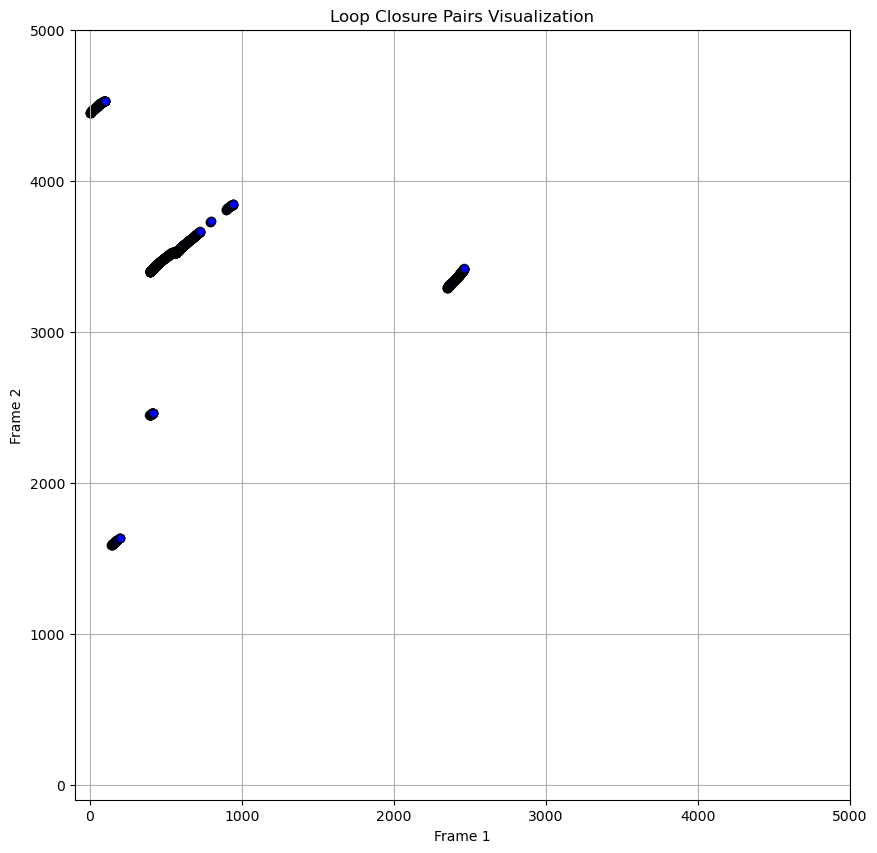

In [12]:
import matplotlib.pyplot as plt

# Separate data into x and y lists
x_vals, y_vals = zip(*loop_closures)

# Plotting
plt.figure(figsize=(10, 10))
plt.scatter(x_vals, y_vals, c='blue', alpha=0.7, edgecolors='k')
plt.title('Loop Closure Pairs Visualization')
plt.xlabel('Frame 1')
plt.ylabel('Frame 2')
# plt.xlim(350, 450)  # Set x-axis range
# plt.ylim(3375, 3425)  # Set y-axis range
plt.xlim(-100, 5000)  # Set x-axis range
plt.ylim(-100, 5000)  # Set y-axis range
plt.grid(True)
plt.show()


In [26]:
def static_lcd_analysis(rot_thresh = 0.3, trans_thresh = 1.5, file_path='/home/ds/Research/lcd/orbslam3_docker/Datasets/KITTI/data_odometry_poses/dataset/poses/00.txt'):
    # Set up your parameters and load the file
    poses = load_poses(file_path)

    # Find loop closure pairs with a minimum frame gap of 30 frames
    min_frame_gap = 300
    loop_closures = find_loop_closures_mycode(poses, min_frame_gap, rot_thresh, trans_thresh, early_stop=-1)

    # Output the loop closures
    print(f'We found {len(loop_closures)} pairs')

    # Separate data into x and y lists
    x_vals, y_vals = zip(*loop_closures)

    # Create an interactive scatter plot with Plotly Graph Objects
    fig = go.Figure()

    # Add scatter trace
    fig.add_trace(go.Scatter(
        x=x_vals,
        y=y_vals,
        mode='markers',
        marker=dict(size=6, color='blue', opacity=0.6),
        name='Loop Closure Pairs'
    ))

    # Configure layout
    pose_number = len(poses)
    fig.update_layout(
        title='Loop Closure Pairs Visualization',
        xaxis=dict(title='Frame 1', range=[-500, pose_number + 500]),
        yaxis=dict(title='Frame 2', range=[-500, pose_number + 500]),
        template='plotly_white'
    )

    # Show the figure
    fig.show()

    return loop_closures


In [27]:
static_lcd_analysis()

Processing frame 0 out of 4541
Processing frame 500 out of 4541
Processing frame 1000 out of 4541
Processing frame 1500 out of 4541
Processing frame 2000 out of 4541
Processing frame 2500 out of 4541
Processing frame 3000 out of 4541
Processing frame 3500 out of 4541
Processing frame 4000 out of 4541
Processing frame 4500 out of 4541
We found 3022 pairs


[(0, 4448),
 (1, 4449),
 (1, 4450),
 (2, 4449),
 (2, 4450),
 (2, 4451),
 (3, 4449),
 (3, 4450),
 (3, 4451),
 (3, 4452),
 (4, 4451),
 (4, 4452),
 (4, 4453),
 (4, 4454),
 (5, 4452),
 (5, 4453),
 (5, 4454),
 (5, 4455),
 (6, 4453),
 (6, 4454),
 (6, 4455),
 (6, 4456),
 (7, 4454),
 (7, 4455),
 (7, 4456),
 (7, 4457),
 (8, 4455),
 (8, 4456),
 (8, 4457),
 (8, 4458),
 (9, 4457),
 (9, 4458),
 (9, 4459),
 (10, 4458),
 (10, 4459),
 (10, 4460),
 (11, 4459),
 (11, 4460),
 (11, 4461),
 (12, 4460),
 (12, 4461),
 (12, 4462),
 (13, 4461),
 (13, 4462),
 (13, 4463),
 (14, 4462),
 (14, 4463),
 (14, 4464),
 (15, 4463),
 (15, 4464),
 (15, 4465),
 (16, 4464),
 (16, 4465),
 (16, 4466),
 (17, 4465),
 (17, 4466),
 (17, 4467),
 (18, 4466),
 (18, 4467),
 (18, 4468),
 (19, 4467),
 (19, 4468),
 (19, 4469),
 (20, 4468),
 (20, 4469),
 (20, 4470),
 (21, 4469),
 (21, 4470),
 (21, 4471),
 (22, 4470),
 (22, 4471),
 (22, 4472),
 (23, 4471),
 (23, 4472),
 (23, 4473),
 (24, 4472),
 (24, 4473),
 (24, 4474),
 (25, 4473),
 (25, 

In [30]:
static_lcd_analysis(0.3, 1)

Processing frame 0 out of 4541
Processing frame 500 out of 4541
Processing frame 1000 out of 4541
Processing frame 1500 out of 4541
Processing frame 2000 out of 4541
Processing frame 2500 out of 4541
Processing frame 3000 out of 4541
Processing frame 3500 out of 4541
Processing frame 4000 out of 4541
Processing frame 4500 out of 4541
We found 1541 pairs


[(2, 4449),
 (2, 4450),
 (3, 4450),
 (3, 4451),
 (3, 4452),
 (4, 4451),
 (4, 4452),
 (4, 4453),
 (5, 4453),
 (5, 4454),
 (6, 4454),
 (6, 4455),
 (7, 4455),
 (7, 4456),
 (8, 4456),
 (8, 4457),
 (8, 4458),
 (9, 4457),
 (9, 4458),
 (9, 4459),
 (10, 4458),
 (10, 4459),
 (10, 4460),
 (11, 4460),
 (11, 4461),
 (12, 4461),
 (12, 4462),
 (13, 4462),
 (13, 4463),
 (14, 4463),
 (14, 4464),
 (15, 4464),
 (15, 4465),
 (16, 4465),
 (16, 4466),
 (17, 4466),
 (17, 4467),
 (18, 4467),
 (18, 4468),
 (19, 4468),
 (19, 4469),
 (20, 4469),
 (20, 4470),
 (21, 4469),
 (21, 4470),
 (22, 4470),
 (22, 4471),
 (23, 4471),
 (23, 4472),
 (24, 4472),
 (24, 4473),
 (25, 4473),
 (25, 4474),
 (26, 4474),
 (26, 4475),
 (27, 4475),
 (27, 4476),
 (28, 4476),
 (28, 4477),
 (29, 4477),
 (29, 4478),
 (30, 4478),
 (30, 4479),
 (31, 4479),
 (31, 4480),
 (32, 4480),
 (32, 4481),
 (33, 4481),
 (34, 4482),
 (35, 4483),
 (36, 4483),
 (36, 4484),
 (37, 4484),
 (37, 4485),
 (38, 4485),
 (38, 4486),
 (39, 4486),
 (39, 4487),
 (40, 

In [ ]:
# Function to calculate loss of matched pairs by netvlad

# Define the loss of matched pairs

# Take netvlad, search 20 candidates with highest scores, 
# Pass temporal consistency check, we should also use 80
# 5 criteria (in ORB2, it's covisibility check)
# Some frames has no matched frames, which is ok
# Matched frames are those passed 80% criteria?                           

In [ ]:
# Write me a search function, which returns the best candidate 
# Loss = trans_loss + 3 * rot_loss

# Say we have 20 candiates frames with Euclidean Distance
# Remove all frames within 50 frames range
